In [88]:
# Import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import warnings
import time
warnings.filterwarnings('ignore')

In [89]:
# Take a glance at the provided data 

raw_data = pd.read_excel('data/dataset.xlsx', engine="openpyxl")

raw_data.info()
raw_data.describe()
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Columns: 111 entries, Patient ID to ctO2 (arterial blood gas analysis)
dtypes: float64(70), int64(4), object(37)
memory usage: 4.8+ MB


,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


----

> Data Observation

The provided data contains 111 entries totally. The 3rd to 6th columns (```SARS-Cov-2 exam result```, etc) are the labels we want to predict. Other columns are features we can exploit to predict corresponding labels. However, these features look messed up now because many values of them are missing or intractable.

In [90]:
# Data preprocessing

raw_data.columns = [x.lower().strip().replace(' ','_') for x in raw_data.columns]

def show_missing_features(x):
    total = x.isnull().sum()
    percent = (x.isnull().sum()/x.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in raw_data.columns:
        dtype = str(x[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

show_missing_features(raw_data)

,patient_id,patient_age_quantile,sars-cov-2_exam_result,"patient_addmited_to_regular_ward_(1=yes,_0=no)","patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)","patient_addmited_to_intensive_care_unit_(1=yes,_0=no)",hematocrit,hemoglobin,platelets,mean_platelet_volume,...,hb_saturation_(arterial_blood_gases),pco2_(arterial_blood_gas_analysis),base_excess_(arterial_blood_gas_analysis),ph_(arterial_blood_gas_analysis),total_co2_(arterial_blood_gas_analysis),hco3_(arterial_blood_gas_analysis),po2_(arterial_blood_gas_analysis),arteiral_fio2,phosphor,cto2_(arterial_blood_gas_analysis)
Total,0,0,0,0,0,0,5041,5041,5042,5045,...,5617,5617,5617,5617,5617,5617,5617,5624,5624,5617
Percent,0.0,0.0,0.0,0.0,0.0,0.0,89.316088,89.316088,89.333806,89.38696,...,99.521616,99.521616,99.521616,99.521616,99.521616,99.521616,99.521616,99.645641,99.645641,99.521616
Types,object,int64,object,int64,int64,int64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


---

> Fill Missing Cells

From the table above, we can clearly see the data type and missing percentage of each feature. A simple approach is filling missing cells with the mean value of existing non-nan cells, or a constant. As for label-typed features, we use ```LabelEncoder```. See [sklearn.preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html) for more details!

In [91]:
# Fill in missing features

for x in raw_data.columns:
    if raw_data[x].dtype=='float16' or  raw_data[x].dtype=='float32' or  raw_data[x].dtype=='float64':
        raw_data[x].fillna(raw_data[x].mean())

raw_data = raw_data.fillna(-999)

# Convert label-typed features
for y in raw_data.columns:
    if raw_data[y].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(raw_data[y].values))
        raw_data[y] = lbl.transform(list(raw_data[y].values))

raw_data.head()

,patient_id,patient_age_quantile,sars-cov-2_exam_result,"patient_addmited_to_regular_ward_(1=yes,_0=no)","patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)","patient_addmited_to_intensive_care_unit_(1=yes,_0=no)",hematocrit,hemoglobin,platelets,mean_platelet_volume,...,hb_saturation_(arterial_blood_gases),pco2_(arterial_blood_gas_analysis),base_excess_(arterial_blood_gas_analysis),ph_(arterial_blood_gas_analysis),total_co2_(arterial_blood_gas_analysis),hco3_(arterial_blood_gas_analysis),po2_(arterial_blood_gas_analysis),arteiral_fio2,phosphor,cto2_(arterial_blood_gas_analysis)
0,1588,13,0,0,0,0,-999.000000,-999.00000,-999.000000,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,451,17,0,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,3669,8,0,0,0,0,-999.000000,-999.00000,-999.000000,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,5457,5,0,0,0,0,-999.000000,-999.00000,-999.000000,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,4843,15,0,0,0,0,-999.000000,-999.00000,-999.000000,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


---

> Feature Engineering

Feature engineering is always the most time-consuming and energy-consuming part of data analysis. And it is not a deterministic step like algorithms and models, but more about engineering experience and trade-offs. 

Here we provide a simple intuition to select useful features: we calculate the correlations between each feature as the covariance matrix, and then remove the features highly correlated with others (which means this column can be easily linear-combined by others). 

In [13]:
# Calculate the covariance matrix

corr_matrix = raw_data.corr().abs()
corr_matrix.head()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,patient_id,patient_age_quantile,sars-cov-2_exam_result,"patient_addmited_to_regular_ward_(1=yes,_0=no)","patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)","patient_addmited_to_intensive_care_unit_(1=yes,_0=no)",hematocrit,hemoglobin,platelets,mean_platelet_volume,...,hb_saturation_(arterial_blood_gases),pco2_(arterial_blood_gas_analysis),base_excess_(arterial_blood_gas_analysis),ph_(arterial_blood_gas_analysis),total_co2_(arterial_blood_gas_analysis),hco3_(arterial_blood_gas_analysis),po2_(arterial_blood_gas_analysis),arteiral_fio2,phosphor,cto2_(arterial_blood_gas_analysis)
patient_id,NaN,0.014136,0.018664,0.003748,0.004803,0.000162,0.002173,0.002167,0.001974,0.002017,...,0.002856,0.002832,0.002847,0.002854,0.002839,0.002840,0.002850,0.005929,0.007077,0.002847
patient_age_quantile,NaN,NaN,0.075244,0.046166,0.015736,0.035772,0.109140,0.109128,0.109860,0.107703,...,0.051720,0.051703,0.051778,0.051778,0.051743,0.051749,0.051730,0.050366,0.020413,0.051732
sars-cov-2_exam_result,NaN,NaN,NaN,0.142437,0.019364,0.027586,0.044974,0.044976,0.045045,0.042017,...,0.088889,0.088836,0.088889,0.088910,0.088845,0.088849,0.088910,0.070122,0.009768,0.088905
"patient_addmited_to_regular_ward_(1=yes,_0=no)",NaN,NaN,NaN,NaN,0.011264,0.010192,0.241889,0.241885,0.242051,0.238041,...,0.144795,0.144685,0.144753,0.144797,0.144703,0.144710,0.144771,0.145138,0.007105,0.144815
"patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)",NaN,NaN,NaN,NaN,NaN,0.008087,0.224213,0.224218,0.224609,0.225239,...,0.267281,0.267521,0.267400,0.267417,0.267440,0.267432,0.267359,0.153438,0.185337,0.267463


In [14]:
threshold = 0.92
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))
dataset = raw_data.drop(columns = to_drop) # dropped data
print('Data shape: ', raw_data.shape)
print('Size of the cleaned data', dataset.shape)

There are 64 columns to remove.
Data shape:  (5644, 111)
Size of the cleaned data (5644, 47)


In [15]:
# Dataset contains selected features

dataset.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Columns: 47 entries, patient_id to phosphor
dtypes: float64(30), int32(13), int64(4)
memory usage: 1.7 MB


---

> **TODO**

**Try to Select or Create Meanful Features from ```raw_data```.**

For example, try dimensionality reduction methods like [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) or [NMF](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization#:~:text=Non-negative) or [Tree-Based models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree) to weight feature's importance. These tools can be easily found in [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition). But it is more encouraged for you to understand the principle behind them and implement them by yourself.

> Requirements
* Conduct feature engineering by using [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) or your own implementation.
* Compare the final test results obtained by your method in your report. 
* Note that you should first read through and complete other parts of this notebook so that you can start for comparison.

In [8]:
# 使用PCA进行数据降维
pca = PCA(n_components=10)
# 去除不能用来预测的数据然后进行降维
label_col = ['patient_id','sars-cov-2_exam_result', 'patient_addmited_to_regular_ward_(1=yes,_0=no)', 'patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)', 'patient_addmited_to_intensive_care_unit_(1=yes,_0=no)']
cols = [x for x in raw_data.columns if x not in label_col] # These columns are the features we can use to predict
new_raw_data = raw_data[cols]
# 进行PCA降维操作
dataset_pca = pca.fit_transform(new_raw_data)
names = ['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5','PCA6','PCA7','PCA8','PCA9','PCA10']
dataset_pca = pd.DataFrame(dataset_pca, columns=names)
print('Data shape: ', new_raw_data.shape)
print('Size of the cleaned data', dataset_pca.shape)

Data shape:  (5644, 106)
Size of the cleaned data (5644, 10)


In [10]:
# Dataset contains selected features

dataset_pca.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Columns: 10 entries, PCA1 to PCA10
dtypes: float64(10)
memory usage: 441.1 KB


In [11]:
# 得到x数据信息
X = dataset_pca
X.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,-459.185996,21.369325,-1.954074,-1.368605,-3.335151,-0.389378,1.397457,-3.896426,-0.036846,-0.956173
1,3825.040571,-963.485107,-354.400607,23.375124,-1162.404300,-252.841174,-124.603161,-92.943234,-186.356377,-149.243155
2,-459.188455,21.369152,-1.948759,-1.370712,-3.330891,-0.393381,1.403495,-3.890143,-0.038344,-0.957530
3,-459.189931,21.369047,-1.945570,-1.371976,-3.328335,-0.395783,1.407118,-3.886373,-0.039243,-0.958344
4,-459.178808,21.372791,-1.957604,-1.365832,-3.343659,-0.385856,1.395991,-3.902127,-0.038087,-0.957735


> Create Dataset and Split Train/Test Data

The following part builds up our dataset and split them into Train/Test Splits.

In [147]:
label_col = ['patient_id','sars-cov-2_exam_result', 'patient_addmited_to_regular_ward_(1=yes,_0=no)', 'patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)', 'patient_addmited_to_intensive_care_unit_(1=yes,_0=no)']
cols = [x for x in dataset.columns if x not in label_col] # These columns are the features we can use to predict

In [148]:
X = dataset[cols]
X.head()

,patient_age_quantile,hematocrit,serum_glucose,respiratory_syncytial_virus,mycoplasma_pneumoniae,neutrophils,urea,proteina_c_reativa_mg/dl,potassium,"influenza_b,_rapid_test",...,"prothrombin_time_(pt),_activity",vitamin_b12,creatine_phosphokinase (cpk),ferritin,arterial_lactic_acid,lipase_dosage,d-dimer,albumin,arteiral_fio2,phosphor
0,13,-999.000000,-999.000000,0,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,17,0.236515,-0.140648,2,-999.0,-0.619086,1.198059,-0.147895,-0.305787,1,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,8,-999.000000,-999.000000,0,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,5,-999.000000,-999.000000,0,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,15,-999.000000,-999.000000,2,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


In [16]:
y = dataset['sars-cov-2_exam_result'] # predict ```sars-cov-2_exam_result``` (Negative/Positive)

# random split to Train/Test with the ratio of 2:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=101) # fixed random seed

---

> **TODO**

**Select and Train Your Model on ```X_train``` and ```y_train```**

We provide an example of ```LogisticRegression``` and ```DecisionTreeClassifier```. Now it's time for your to select the model you like to conduct classification.

> Requirements
* Select at least **three** other Machine Learning models and train them on the Train split. And you should implement at least **one** by yourself.

In [140]:
accuracy_lst =[]

def model_assess(model, name='Default'):
    model.fit(X_train, y_train)
    prds = model.predict(X_test)
    model_acc = accuracy_score(y_test, prds)
    accuracy_lst.append(100*model_acc)
    print('Accuracy:', (accuracy_score(y_test, prds)), '\n')

In [141]:
# Logistic Regression
lg = LogisticRegression()
model_assess(lg, 'Logistic Regression')

Accuracy: 0.9028448738593666 



In [142]:
# Decision Tree
tree = DecisionTreeClassifier()
model_assess(tree, 'Decission Trees')

Accuracy: 0.8926462694578636 



In [143]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
prds = lr.predict(X_test)
for i in range(len(prds)):
    if prds[i] >=0.5:
        prds[i] = 1
    else: 
        prds[i] = 0 
model_acc = accuracy_score(y_test, prds)
accuracy_lst.append(100*model_acc)
print('Accuracy:', (accuracy_score(y_test, prds)), '\n')

Accuracy: 0.9028448738593666 



In [144]:
# KNN
knn_x_train = np.array(X_train)
knn_y_train = np.array(y_train)
k = 5
knn_x_test = np.array(X_test)
prds = []
for i in range(len(knn_x_test)):
    location = []
    for j in range(len(knn_x_train)):
        item = {}
        item['dis'] = np.sqrt(np.sum(np.square(knn_x_train[j] - knn_x_test[i])))
        item['label'] = knn_y_train[j]
        location.append(item)
    location.sort(key=lambda x: x['dis'], reverse=False)
    result = []
    for z in range(k):
        result.append(location[z]['label'])
    label = max(set(result), key=result.count)
    prds.append(label)
model_acc = accuracy_score(y_test, prds)
accuracy_lst.append(100*model_acc)
print('Accuracy:', (accuracy_score(y_test, prds)), '\n')

Accuracy: 0.9023081052066559 



In [145]:
# Random Forest
rf = RandomForestRegressor()
model_assess(lg, 'Random Forest')

Accuracy: 0.9028448738593666 



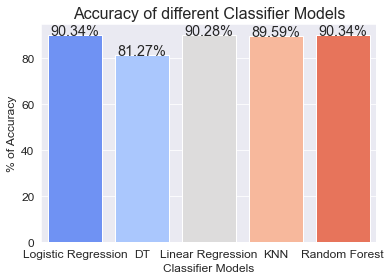

In [131]:
# Demostrate model results on Train split

model_list = ['Logistic Regression', 'DT', 'Linear Regression', 'KNN','Random Forest']

plt.rcParams['figure.figsize']=6,4
sns.set_style('darkgrid')
ax = sns.barplot(x=model_list, y = accuracy_lst, palette = "coolwarm", saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 12)
plt.ylabel('% of Accuracy', fontsize = 12)
plt.title('Accuracy of different Classifier Models', fontsize = 16)
plt.xticks(fontsize = 12, horizontalalignment = 'center')
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height), ha='center', fontsize = 'x-large')
plt.show()

In [132]:
# Cross-validaiton

cross_acc = []

ca_lg = cross_val_score(lg, X_train, y_train, scoring='accuracy')
ca_lg = ca_lg.mean()
cross_acc.append(100*ca_lg)

ca_tree = cross_val_score(tree, X_train, y_train, scoring='accuracy')
ca_tree = ca_tree.mean()
cross_acc.append(100*ca_tree)

ca_lr = cross_val_score(lr, X_train, y_train, scoring='accuracy')
ca_lr = ca_lr.mean()
cross_acc.append(100*ca_tree)

ca_lr = cross_val_score(lr, X_train, y_train, scoring='accuracy')
ca_lr = ca_lr.mean()
cross_acc.append(100*ca_tree)

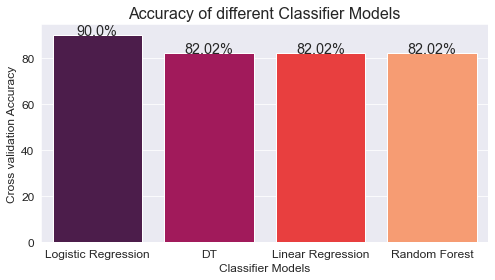

In [133]:
# Demostrate model results on Test split

model_list = ['Logistic Regression', 'DT', 'Linear Regression','Random Forest']

plt.rcParams['figure.figsize']=8,4
sns.set_style('darkgrid')
ax = sns.barplot(x=model_list, y=cross_acc, palette = "rocket", saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 12 )
plt.ylabel('Cross validation Accuracy', fontsize = 12)
plt.title('Accuracy of different Classifier Models', fontsize = 16)
plt.xticks(fontsize = 12, horizontalalignment = 'center')
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height), ha='center', fontsize = 'x-large')
plt.show()

---

> **TODO**

**Tune Model for Good Performance on Test Split**

The final objective for training is to obtain a model that performs well on the unseen Test split (not to overfit the Train split). Now it is your time to provide the final solution.

> Requirements
* Try more evaluation methods (like Confusion Matrix, AUC curve and etc.) to make your results more convincing.
* Tune model's hyperparameters by cross-validation and evaluate all your selected models. And give a detailed report on the performance and computational efficiency.
* It is appreciated if other machine learning techniques that help to improve performance are employed.

**Linear Regression部分**

epoch: 0
cur_MSR: 0.09801967044301976
epoch: 1
cur_MSR: 0.08142115839182845
epoch: 2
cur_MSR: 0.09924545248858319
epoch: 3
cur_MSR: 0.0980749945381742
epoch: 4
cur_MSR: 0.07504869796492762
epoch: 5
cur_MSR: 0.09126431112106048
epoch: 6
cur_MSR: 0.09386738479021439
epoch: 7
cur_MSR: 0.08452211104630192
epoch: 8
cur_MSR: 0.09412142060825773
epoch: 9
cur_MSR: 0.08517583407087924
epoch: 10
cur_MSR: 0.09394807075437127
epoch: 11
cur_MSR: 0.07946876215181069
epoch: 12
cur_MSR: 0.0796586571318507
epoch: 13
cur_MSR: 0.09969649605968485
epoch: 14
cur_MSR: 0.08552462539694536
epoch: 15
cur_MSR: 0.0995654354488994
epoch: 16
cur_MSR: 0.08373558162283297
epoch: 17
cur_MSR: 0.09205733868859332
epoch: 18
cur_MSR: 0.08960294076363011
epoch: 19
cur_MSR: 0.11124467359897745
epoch: 20
cur_MSR: 0.09684814120353573
epoch: 21
cur_MSR: 0.08815093138482177
epoch: 22
cur_MSR: 0.08886039685679632
epoch: 23
cur_MSR: 0.10241147110584356
epoch: 24
cur_MSR: 0.08648661281229958
epoch: 25
cur_MSR: 0.09408019955124475

Text(0, 0.5, 'Score')

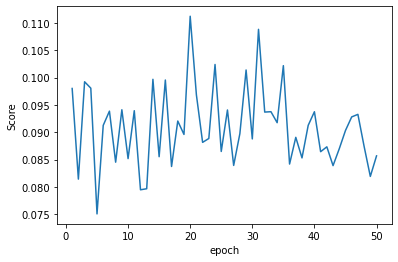

In [70]:
# 训练Linear Regression
time_start = time.time()
epoch = 50
best_MSE = 233
scores = []
for i in range(epoch):
    print("epoch:", i)

    # 划分训练集和验证集
    X_new_train, X_validate, y_new_train, y_validate = train_test_split(X_train, y_train, test_size=0.25)

    # 训练线性回归模型
    cur_model = LinearRegression()
    cur_model.fit(X_new_train, y_new_train)
    y_pred = cur_model.predict(X_validate)

    # 取最好的模型返回
    cur_MSE = metrics.mean_squared_error(y_validate, y_pred)
    print("cur_MSR:", cur_MSE)
    scores.append(cur_MSE)
    if cur_MSE < best_MSE:
        best_MSE = cur_MSE
        best_model = cur_model
        
time_end = time.time()
print('\n')
print("训练时长（单位s）:",time_end - time_start)
plt.figure()
plt.plot(range(1,51), scores)
plt.xlabel('epoch')
plt.ylabel('Score')

Text(0.5, 0, 'False Positive Rate')

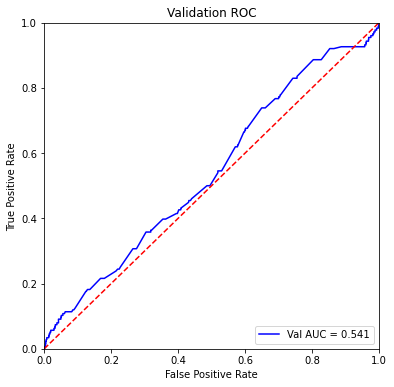

In [18]:
#结果分析
#绘制AUC曲线
pred = best_model.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [24]:
#准确率
for i in range(len(pred)):
    if pred[i] >=0.5:
        pred[i] = 1
    else: 
        pred[i] = 0 
print('Accuracy:', (accuracy_score(y_test, pred)), '\n')

Accuracy: 0.9033816425120773 



In [30]:
#混淆矩阵
confusion_matrix(y_test, pred)

array([[1681,    6],
       [ 174,    2]], dtype=int64)

**KNN部分**

train: 1  cur_score: -1.030080240405939
train: 2  cur_score: -0.45452588478955513
train: 3  cur_score: -0.2699274393999101
train: 4  cur_score: -0.1925340655804751
train: 5  cur_score: -0.15005878092570385
train: 6  cur_score: -0.13743139690523803
train: 7  cur_score: -0.11447749406264726
train: 8  cur_score: -0.10934731080111884
train: 9  cur_score: -0.08800189811820672
train: 10  cur_score: -0.07353047916928578
train: 11  cur_score: -0.07014968875525732
train: 12  cur_score: -0.055019579425183804
train: 13  cur_score: -0.04428452215283596
train: 14  cur_score: -0.037455891804799
train: 15  cur_score: -0.03927634942804677
train: 16  cur_score: -0.034893427073752134
train: 17  cur_score: -0.03444931713607324
train: 18  cur_score: -0.028580982584600657
train: 19  cur_score: -0.02939947478312872
train: 20  cur_score: -0.02696129269053128
train: 21  cur_score: -0.02477268513755082
train: 22  cur_score: -0.021281243601915488
train: 23  cur_score: -0.020235156477070824
train: 24  cur_score:

Text(0, 0.5, 'Score')

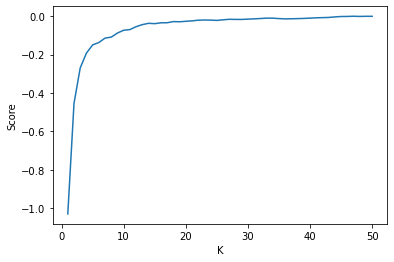

In [71]:
# 训练KNN(在上面已经自己实现了KNN，这里训练超参数使用相应的函数)
time_start = time.time()
k_range = range(1, 51)
best_score = -1000
scores = []
# 交叉验证
for k in k_range:
    cur_model = KNeighborsRegressor(k)
    cur_score = cross_val_score(cur_model, X_train, y_train, cv=10).mean()
    scores.append(cur_score)
    print("train:", k, ' cur_score:',cur_score)

    # 取最好的模型返回
    if cur_score > best_score:
        best_score = cur_score
        best_model = cur_model

time_end = time.time()
print('\n')
print("训练时长（单位s）:",time_end - time_start)
plt.figure()
plt.plot(k_range, scores)
plt.xlabel('K')
plt.ylabel('Score')

[0.06382979 0.17021277 0.10638298 ... 0.08510638 0.14893617 0.19148936]


Text(0.5, 0, 'False Positive Rate')

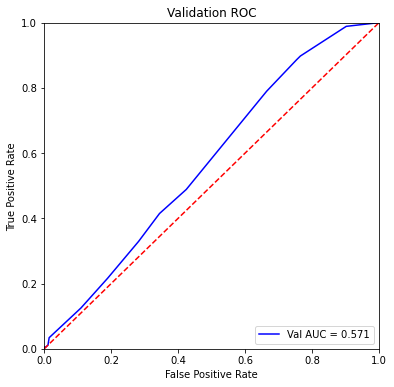

In [59]:
#结果分析
#绘制AUC曲线
best_model.fit(X_train, y_train)
pred = best_model.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [60]:
#准确率
for i in range(len(pred)):
    if pred[i] >=0.5:
        pred[i] = 1
    else: 
        pred[i] = 0 
print('Accuracy:', (accuracy_score(y_test, pred)), '\n')

Accuracy: 0.90552871712292 



In [61]:
#混淆矩阵
confusion_matrix(y_test, pred)

array([[1687,    0],
       [ 176,    0]], dtype=int64)

**Random Forest部分**

train: 10 20
train: 10 40
train: 10 60
train: 10 80
train: 10 100
train: 20 20
train: 20 40
train: 20 60
train: 20 80
train: 20 100
train: 30 20
train: 30 40
train: 30 60
train: 30 80
train: 30 100
train: 40 20
train: 40 40
train: 40 60
train: 40 80
train: 40 100
train: 50 20
train: 50 40
train: 50 60
train: 50 80
train: 50 100
train: 60 20
train: 60 40
train: 60 60
train: 60 80
train: 60 100
train: 70 20
train: 70 40
train: 70 60
train: 70 80
train: 70 100
train: 80 20
train: 80 40
train: 80 60
train: 80 80
train: 80 100
train: 90 20
train: 90 40
train: 90 60
train: 90 80
train: 90 100
train: 100 20
train: 100 40
train: 100 60
train: 100 80
train: 100 100
RandomForestRegressor(max_depth=40, n_estimators=20)


Text(0, 0.5, 'Score')

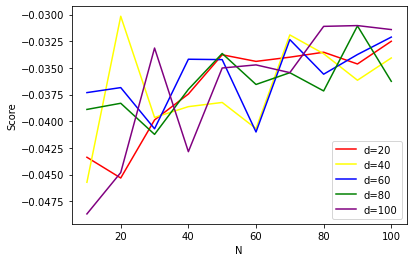

In [62]:
# 训练Random Forest
time_start = time.time()
n_range = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
d_range = [20, 40, 60, 80, 100]

best_score = -1000
scores = [[] for i in range(len(d_range))]

# 交叉验证
for n in n_range:
    for d in d_range:
        print("train:", n, d)
        cur_model = RandomForestRegressor(n_estimators=n, max_depth=d)
        cur_score = cross_val_score(cur_model, X_train, y_train, cv=10).mean()
        scores[int(d / 20) - 1].append(cur_score)

        # 取最好的模型返回
        if cur_score > best_score:
            best_score = cur_score
            best_model = cur_model

time_end = time.time()
print('\n')
print("训练时长（单位s）:",time_end - time_start)
plt.figure()
plt.plot(n_range, scores[0], color="red", label="d=20")
plt.plot(n_range, scores[1], color="yellow", label="d=40")
plt.plot(n_range, scores[2], color="blue", label="d=60")
plt.plot(n_range, scores[3], color="green", label="d=80")
plt.plot(n_range, scores[4], color="purple", label="d=100")
plt.legend()

plt.xlabel('N')
plt.ylabel('Score')

Text(0.5, 0, 'False Positive Rate')

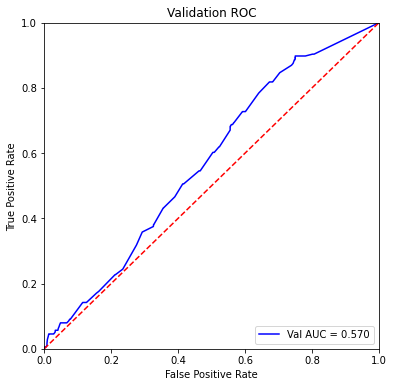

In [63]:
#结果分析
#绘制AUC曲线
best_model.fit(X_train, y_train)
pred = best_model.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [64]:
#准确率
for i in range(len(pred)):
    if pred[i] >=0.5:
        pred[i] = 1
    else: 
        pred[i] = 0 
print('Accuracy:', (accuracy_score(y_test, pred)), '\n')

Accuracy: 0.8974771873322598 



In [65]:
#混淆矩阵
confusion_matrix(y_test, pred)

array([[1664,   23],
       [ 168,    8]], dtype=int64)

---

> **TODO**

**Try to Predict for Another Task**

Now, your are familiar with the simple pipeline of data mining. The final task for you is to explore the ```data/dataset.xlsx``` to predict one of the labels above:
* ```patient_addmited_to_regular_ward_(1=yes,_0=no)```
* ```patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)```
* ```patient_addmited_to_intensive_care_unit_(1=yes,_0=no)```

> Requirements
* Use **Row 5001-5645** of ```data/dataset.xlsx``` as the Test Split. Write code or a jupyter notebook to show how you solve this task. Please give detailed comments of your code and a good demonstration of your results.


In [98]:
# 处理数据，分为训练集和测试集
raw_data_train = raw_data.loc[0:4998]
raw_data_test = raw_data.loc[4999:]

In [99]:
# 对训练集数据进行特征提取，然后去除不用的列项
# Calculate the covariance matrix
corr_matrix = raw_data_train.corr().abs()
corr_matrix.head()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,patient_id,patient_age_quantile,sars-cov-2_exam_result,"patient_addmited_to_regular_ward_(1=yes,_0=no)","patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)","patient_addmited_to_intensive_care_unit_(1=yes,_0=no)",hematocrit,hemoglobin,platelets,mean_platelet_volume,...,hb_saturation_(arterial_blood_gases),pco2_(arterial_blood_gas_analysis),base_excess_(arterial_blood_gas_analysis),ph_(arterial_blood_gas_analysis),total_co2_(arterial_blood_gas_analysis),hco3_(arterial_blood_gas_analysis),po2_(arterial_blood_gas_analysis),arteiral_fio2,phosphor,cto2_(arterial_blood_gas_analysis)
patient_id,NaN,0.011576,0.016324,0.001791,0.008830,0.012383,0.006375,0.006368,0.006181,0.006290,...,0.024309,0.024311,0.024320,0.024311,0.024319,0.024320,0.024296,0.009254,0.009798,0.024286
patient_age_quantile,NaN,NaN,0.048937,0.017922,0.018636,0.004587,0.107434,0.107422,0.108278,0.107334,...,0.035396,0.035420,0.035426,0.035410,0.035432,0.035432,0.035395,0.034389,0.018392,0.035397
sars-cov-2_exam_result,NaN,NaN,NaN,0.089759,0.007845,0.034071,0.022803,0.022806,0.022880,0.023191,...,0.010222,0.010213,0.010198,0.010206,0.010198,0.010197,0.010220,0.008990,0.001012,0.010234
"patient_addmited_to_regular_ward_(1=yes,_0=no)",NaN,NaN,NaN,NaN,0.008440,0.006528,0.183628,0.183631,0.183850,0.184114,...,0.046278,0.046249,0.046290,0.046299,0.046271,0.046274,0.046244,0.054553,0.005871,0.046262
"patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)",NaN,NaN,NaN,NaN,NaN,0.005454,0.191901,0.191892,0.192320,0.192514,...,0.176608,0.176743,0.176646,0.176628,0.176674,0.176669,0.176672,0.066352,0.201141,0.176736


In [100]:
threshold = 0.92
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# 根据训练集数据的特征情况对原数据进行降维，然后再重新按照之前的行数分训练集和测试集
print('There are %d columns to remove.' % (len(to_drop)))
dataset = raw_data.drop(columns = to_drop) # dropped data
print('Data shape: ', raw_data.shape)
print('Size of the cleaned data', dataset.shape)

There are 65 columns to remove.
Data shape:  (5644, 111)
Size of the cleaned data (5644, 46)


In [101]:
# Dataset contains selected features

dataset.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Columns: 46 entries, patient_id to phosphor
dtypes: float64(29), int32(13), int64(4)
memory usage: 1.7 MB


In [102]:
label_col = ['patient_id','sars-cov-2_exam_result', 'patient_addmited_to_regular_ward_(1=yes,_0=no)', 'patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)', 'patient_addmited_to_intensive_care_unit_(1=yes,_0=no)']
cols = [x for x in dataset.columns if x not in label_col] # These columns are the features we can use to predict

In [103]:
X = dataset[cols]
X.head()

,patient_age_quantile,hematocrit,serum_glucose,respiratory_syncytial_virus,mycoplasma_pneumoniae,urea,proteina_c_reativa_mg/dl,potassium,"influenza_b,_rapid_test",alanine_transaminase,...,"prothrombin_time_(pt),_activity",vitamin_b12,creatine_phosphokinase (cpk),ferritin,arterial_lactic_acid,lipase_dosage,d-dimer,albumin,arteiral_fio2,phosphor
0,13,-999.000000,-999.000000,0,-999.0,-999.000000,-999.000000,-999.000000,0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,17,0.236515,-0.140648,2,-999.0,1.198059,-0.147895,-0.305787,1,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,8,-999.000000,-999.000000,0,-999.0,-999.000000,-999.000000,-999.000000,0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,5,-999.000000,-999.000000,0,-999.0,-999.000000,-999.000000,-999.000000,0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,15,-999.000000,-999.000000,2,-999.0,-999.000000,-999.000000,-999.000000,0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


In [110]:
y = dataset['patient_addmited_to_regular_ward_(1=yes,_0=no)'] # predict ```patient_addmited_to_regular_ward_(1=yes,_0=no)```

# 进行数据分割
X_train = X.loc[0:4998]
X_test = X.loc[4999:]
y_train = y.loc[0:4998]
y_test = y.loc[4999:]

**Linear Regression部分**

epoch: 0 cur_MSE: 0.011645291898433364
epoch: 1 cur_MSE: 0.009317568405184056
epoch: 2 cur_MSE: 0.007167924277904643
epoch: 3 cur_MSE: 0.012800238460164098
epoch: 4 cur_MSE: 0.012624880863003805
epoch: 5 cur_MSE: 3.5392328882019117
epoch: 6 cur_MSE: 0.009215771646329923
epoch: 7 cur_MSE: 0.013078212087580454
epoch: 8 cur_MSE: 0.015707537325206026
epoch: 9 cur_MSE: 0.010967058640895758
epoch: 10 cur_MSE: 0.009086492287512854
epoch: 11 cur_MSE: 0.015436927939901068
epoch: 12 cur_MSE: 0.012016117653363976
epoch: 13 cur_MSE: 0.009917308996014125
epoch: 14 cur_MSE: 0.00954735538241181
epoch: 15 cur_MSE: 0.010099325386987755
epoch: 16 cur_MSE: 0.0117511676817195
epoch: 17 cur_MSE: 0.01324697517528004
epoch: 18 cur_MSE: 0.00981813350879756
epoch: 19 cur_MSE: 0.008678555077119204
epoch: 20 cur_MSE: 0.009247182378400614
epoch: 21 cur_MSE: 0.00852658046478996
epoch: 22 cur_MSE: 0.011741176560120437
epoch: 23 cur_MSE: 0.014087617328365845
epoch: 24 cur_MSE: 0.009339241061037118
epoch: 25 cur_MSE:

Text(0, 0.5, 'Score')

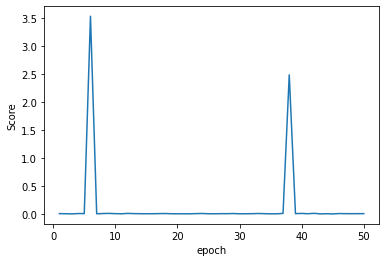

In [125]:
# 训练Linear Regression
time_start = time.time()
epoch = 50
best_MSE = 233
scores = []
for i in range(epoch):
    # 划分训练集和验证集
    X_new_train, X_validate, y_new_train, y_validate = train_test_split(X_train, y_train, test_size=0.25)

    # 训练线性回归模型
    cur_model = LinearRegression()
    cur_model.fit(X_new_train, y_new_train)
    y_pred = cur_model.predict(X_validate)

    # 取最好的模型返回
    cur_MSE = metrics.mean_squared_error(y_validate, y_pred)
    print("epoch:", i, "cur_MSE:", cur_MSE)
    scores.append(cur_MSE)
    if cur_MSE < best_MSE:
        best_MSE = cur_MSE
        best_model = cur_model
        
time_end = time.time()
print('\n')
print("训练时长（单位s）:",time_end - time_start)
plt.figure()
plt.plot(range(1,51), scores)
plt.xlabel('epoch')
plt.ylabel('Score')

Text(0.5, 0, 'False Positive Rate')

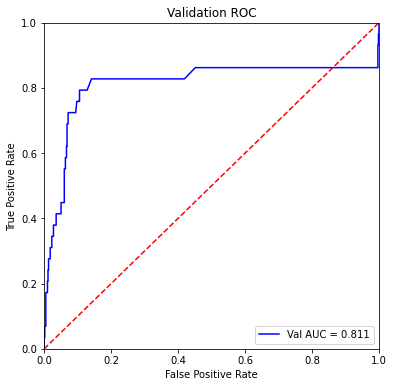

In [112]:
#结果分析
#绘制AUC曲线
pred = best_model.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [113]:
#准确率
for i in range(len(pred)):
    if pred[i] >=0.5:
        pred[i] = 1
    else: 
        pred[i] = 0 
print('Accuracy:', (accuracy_score(y_test, pred)), '\n')

Accuracy: 0.9565891472868217 



In [114]:
#混淆矩阵
confusion_matrix(y_test, pred)

array([[616,   0],
       [ 28,   1]], dtype=int64)

**KNN部分**

train: 1  cur_score: -0.48973098487065314
train: 2  cur_score: -0.2732935770229459
train: 3  cur_score: -0.2545444357909891
train: 4  cur_score: -0.23054092962522305
train: 5  cur_score: -0.170764951599281
train: 6  cur_score: -0.14173315705497444
train: 7  cur_score: -0.11804789425246125
train: 8  cur_score: -0.09870804247216289
train: 9  cur_score: -0.09207825095589502
train: 10  cur_score: -0.07071900212649133
train: 11  cur_score: -0.06276830848021636
train: 12  cur_score: -0.0556458854112485
train: 13  cur_score: -0.053341039752710394
train: 14  cur_score: -0.045927253857364604
train: 15  cur_score: -0.039780996218675
train: 16  cur_score: -0.03243961677216721
train: 17  cur_score: -0.021784150677167692
train: 18  cur_score: -0.02104652947299568
train: 19  cur_score: -0.013093416381911627
train: 20  cur_score: -0.009766162696760571
train: 21  cur_score: -0.0060212164750130135
train: 22  cur_score: -0.010558512392622964
train: 23  cur_score: -0.011343182694993625
train: 24  cur_sco

Text(0, 0.5, 'Score')

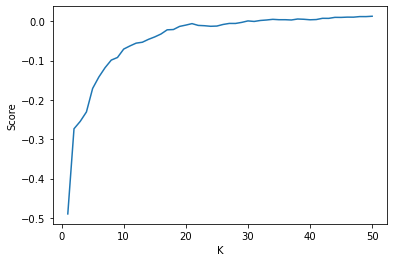

In [115]:
# 训练KNN
time_start = time.time()
k_range = range(1, 51)
best_score = -1000
scores = []
# 交叉验证
for k in k_range:
    cur_model = KNeighborsRegressor(k)
    cur_score = cross_val_score(cur_model, X_train, y_train, cv=10).mean()
    scores.append(cur_score)
    print("train:", k, ' cur_score:',cur_score)

    # 取最好的模型返回
    if cur_score > best_score:
        best_score = cur_score
        best_model = cur_model

time_end = time.time()
print('\n')
print("训练时长（单位s）:",time_end - time_start)
plt.figure()
plt.plot(k_range, scores)
plt.xlabel('K')
plt.ylabel('Score')

Text(0.5, 0, 'False Positive Rate')

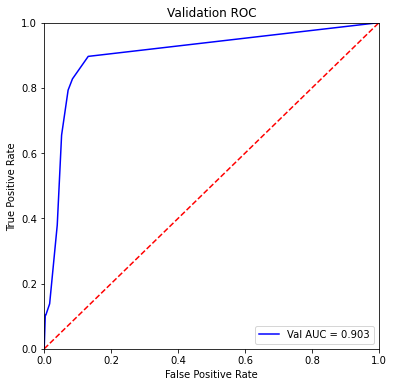

In [116]:
#结果分析
#绘制AUC曲线
best_model.fit(X_train, y_train)
pred = best_model.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [117]:
#准确率
for i in range(len(pred)):
    if pred[i] >=0.5:
        pred[i] = 1
    else: 
        pred[i] = 0 
print('Accuracy:', (accuracy_score(y_test, pred)), '\n')

Accuracy: 0.9550387596899225 



In [118]:
#混淆矩阵
confusion_matrix(y_test, pred)

array([[616,   0],
       [ 29,   0]], dtype=int64)

**Random Forest部分**

train: 10 20 cur_score: -0.08859068597820698
train: 10 40 cur_score: -0.10599463073020957
train: 10 60 cur_score: -0.07855471802801514
train: 10 80 cur_score: -0.10356498284756122
train: 10 100 cur_score: -0.0757218643033274
train: 20 20 cur_score: -0.045740110322587145
train: 20 40 cur_score: -0.10223792052567635
train: 20 60 cur_score: -0.08317224703473665
train: 20 80 cur_score: -0.07495279682670028
train: 20 100 cur_score: -0.06884621303576274
train: 30 20 cur_score: -0.032751865666946045
train: 30 40 cur_score: -0.05759030101975106
train: 30 60 cur_score: -0.0675139121907147
train: 30 80 cur_score: -0.0551023846986729
train: 30 100 cur_score: -0.05840252335200371
train: 40 20 cur_score: -0.03761925614076855
train: 40 40 cur_score: -0.05678388403561181
train: 40 60 cur_score: -0.02782617552270248
train: 40 80 cur_score: -0.0474360435240377
train: 40 100 cur_score: -0.046793979704052954
train: 50 20 cur_score: -0.05027202990114101
train: 50 40 cur_score: -0.05538343478873424
train: 

Text(0, 0.5, 'Score')

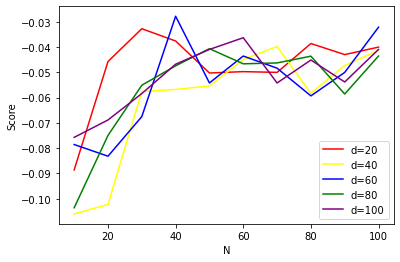

In [126]:
# 训练Random Forest
time_start = time.time()
n_range = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
d_range = [20, 40, 60, 80, 100]

best_score = -1000
scores = [[] for i in range(len(d_range))]

# 交叉验证
for n in n_range:
    for d in d_range:
        cur_model = RandomForestRegressor(n_estimators=n, max_depth=d)
        cur_score = cross_val_score(cur_model, X_train, y_train, cv=10).mean()
        scores[int(d / 20) - 1].append(cur_score)
        print("train:", n, d, "cur_score:", cur_score)
        # 取最好的模型返回
        if cur_score > best_score:
            best_score = cur_score
            best_model = cur_model

time_end = time.time()
print('\n')
print("训练时长（单位s）:",time_end - time_start)
plt.figure()
plt.plot(n_range, scores[0], color="red", label="d=20")
plt.plot(n_range, scores[1], color="yellow", label="d=40")
plt.plot(n_range, scores[2], color="blue", label="d=60")
plt.plot(n_range, scores[3], color="green", label="d=80")
plt.plot(n_range, scores[4], color="purple", label="d=100")
plt.legend()

plt.xlabel('N')
plt.ylabel('Score')

Text(0.5, 0, 'False Positive Rate')

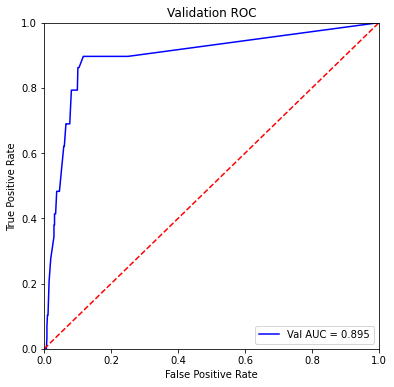

In [127]:
#结果分析
#绘制AUC曲线
best_model.fit(X_train, y_train)
pred = best_model.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [128]:
#准确率
for i in range(len(pred)):
    if pred[i] >=0.5:
        pred[i] = 1
    else: 
        pred[i] = 0 
print('Accuracy:', (accuracy_score(y_test, pred)), '\n')

Accuracy: 0.9503875968992248 



In [129]:
#混淆矩阵
confusion_matrix(y_test, pred)

array([[613,   3],
       [ 29,   0]], dtype=int64)

---